# Drift analysis notebook

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from salishsea_tools import viz_tools
from tqdm.notebook import tqdm

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Functions

In [3]:
def mtime2datetime(mtime):
    """Convert matlab time to python datetime object
    """
    
    pytime = datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)
    
    return pytime


def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    prefix = {}
    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    NEMO = os.path.join(paths['NEMO'], datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    prefix['NEMO_U'] = NEMO + '_grid_U.nc'
    prefix['NEMO_V'] = NEMO + '_grid_V.nc'
    prefix['WW3'] = os.path.join(paths['WW3'], datestr[0], f'SoG_ww3_fields_{datestr[1]}.nc')
    prefix['HRDPS'] = os.path.join(paths['HRDPS'], f"ops_{date.strftime('y%Ym%md%d')}.nc")
    
    return prefix


def wind_drift(particle, fieldset, time):
    (uw, vw) = fieldset.UVw[time, particle.depth, particle.lat, particle.lon]
    particle.lon += uw * 0.03 * particle.dt
    particle.lat += vw * 0.03 * particle.dt


def stokes_drift(particle, fieldset, time):
    (us, vs) = fieldset.UVs[time, particle.depth, particle.lat, particle.lon]
    particle.lon += us * particle.dt
    particle.lat += vs * particle.dt


def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

***

### Processing code

Define variables

In [4]:
# Paths, files and definitions
paths = {
    'NEMO': '/results2/SalishSea/hindcast.201905',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'WW3': '/opp/wwatch3/nowcast',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'drifters': '/ocean/shared/drifters/data/L3/Salish_L3_20190728T103529.mat',
    'out': '/data/bmoorema/results/parcels/drifters_transects',
}
grid = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
drifters = loadmat(paths['drifters'])['drift'][0]

# Define Gaussian point cloud
n = 50   # number of particles
r = 10   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], n).T

# Duration and timestep [s]
duration = timedelta(days=3)
dt = 90

# Construct list of drifters inside SSC domain
IDs, IDout = list(np.unique(drifters['id'].astype(int))), []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if drifters['lon'][dindex][0] < -124.5: IDout.append(ID)
IDout = list(np.unique(IDout))
for ID in IDout: IDs.remove(ID)

Select drifter IDs by transect

In [5]:
# Isolate drifter transects
selected = {}
for key, vals in zip(['lon', 'lat'], [(-123.7, -123.3), (48.95, 48.5)]):
    for val, attr, latcut in zip(vals, ['less', 'greater'], [49, 48.5]):
        
        # Define dict field
        name = f'{key}{abs(val)}'
        selected[name] = {'ID': [], 'isect': []}

        # Select drifters that cross specific transects
        for ID in IDs:
            dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
            isect = np.where(abs(drifters[key][dindex] - val) < 0.001)[0]
            if isect.size > 0:
                isect = isect[0]
                if not (key == 'lon') & (getattr(np, attr)(drifters['lat'][dindex][isect], latcut)):
                    if drifters[key][dindex][isect+1] < drifters[key][dindex][isect]:
                        if len(drifters['lon'][dindex][isect:]) > 720:
                            selected[name]['ID'].append(ID)
                            selected[name]['isect'].append(isect)

In [11]:
selected.keys()

dict_keys(['lon123.7', 'lon123.3', 'lat48.95', 'lat48.5'])

Plot selected transects

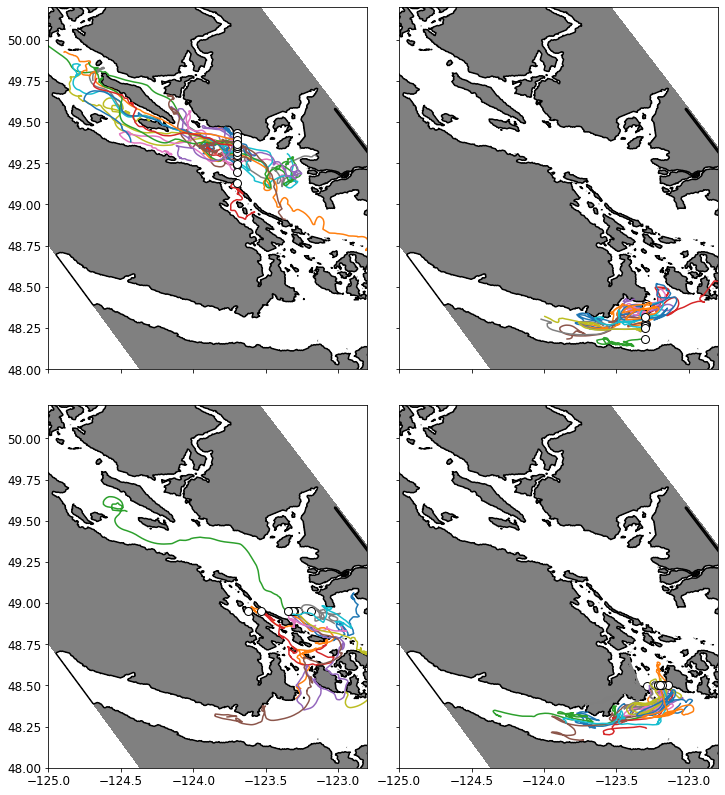

In [17]:
# Plot drift tracks
fig, axs = plt.subplots(2, 2, figsize=(12, 14), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axs = axs.reshape(4)

# Loop through plots
for ax, key in zip(axs, selected):
        
    # Make plot panel
    cmap = plt.cm.get_cmap('tab20')
    ax.set_xlim([-125, -122.8])
    ax.set_ylim([48, 50.2])
    ax.contourf(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
    ax.contour(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    viz_tools.set_aspect(ax)
    if key in ['lon123.7', 'lon123.3']: ax.xaxis.set_ticklabels('')
    if key in ['lon123.3', 'lat48.5']: ax.yaxis.set_ticklabels('')

    # Select drifters that cross specific transects
    for ID, isect in zip(selected[key]['ID'], selected[key]['isect']):
        dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
        ax.plot(drifters['lon'][dindex][isect:isect+720], drifters['lat'][dindex][isect:isect+720], label=ID)
        ax.plot(drifters['lon'][dindex][isect], drifters['lat'][dindex][isect], 'ko', markerfacecolor='w', markersize=8)

fig.savefig('/home/bmoorema/Desktop/drift_transects.pdf', bbox_inches='tight')

***

## Simulations

In [186]:
# Loop through drifters
tsect = 'lon123.3'

for ID, isect in zip(selected[tsect]['ID'], selected[tsect]['isect']):

    # Create index and date identifiers for drifter ID
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start = mtime2datetime(float(drifters['mtime'][dindex][isect]))

    # Define run paths
    fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
    outfile = os.path.join(paths['out'], 'base', tsect, fn)

    # Build filenames
    files = {}
    for day in range(-1, duration.days + 3):
        prefix = make_prefix(start + timedelta(days=day), paths)
        for key in prefix:
            if key not in files: files[key] = []
            files[key].append(prefix[key])

    # Load NEMO forcing
    filenames = {
        'U': {'lon': paths['coords'], 'lat': paths['coords'], 'data': files['NEMO_U']},
        'V': {'lon': paths['coords'], 'lat': paths['coords'], 'data': files['NEMO_V']},
    }
    variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
    dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, field_chunksize='auto')

    # ------------- start load HRDPS -----------------
    wind_on = False
    if wind_on:
        # Create corrected lon coords file
        filename = os.path.join(paths['out'], 'HRDPS_grid.nc')
        if not os.path.exists(filename):
            with xr.open_dataset(files['HRDPS'][0]) as ds:
                data_vars = list(ds.data_vars)
                for key in ['nav_lon', 'nav_lat']: data_vars.remove(key)
                ds = ds.drop_vars(data_vars)
                ds.update({'nav_lon': ds.nav_lon - 360})
                ds.to_netcdf(filename)

        # Construct fieldset
        variables = {'lon': filename, 'lat': filename, 'data': files['HRDPS']}
        dimensions = {'lon': 'nav_lon', 'lat': 'nav_lat', 'time': 'time_counter'}
        Uw = Field.from_netcdf(variables, ('Uw', 'u_wind'), dimensions, fieldtype='U', field_chunksize='auto')
        Vw = Field.from_netcdf(variables, ('Vw', 'v_wind'), dimensions, fieldtype='V', grid=Uw.grid, dataFiles=Uw.dataFiles, field_chunksize='auto')
        field_set.add_field(Uw)
        field_set.add_field(Vw)
        field_set.add_vector_field(VectorField('UVw', field_set.Uw, field_set.Vw))
    # ------------- end load HRDPS -----------------

    # Execute run
    lon, lat = drifters['lon'][dindex][isect] + x_offset, drifters['lat'][dindex][isect] + y_offset
    pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, time=start)
    kernel = AdvectionRK4 #+ pset.Kernel(wind_drift)
    pset.execute(
        kernel, runtime=duration, dt=dt,
        output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
        recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
    )

***

## Results

Functions

In [40]:
def plot_drifters(ax, tsect, bounds):
    """
    """

    for ax, ID, isect in zip(axs, selected[tsect]['ID'], selected[tsect]['isect']):
    #ID, isect = selected[tsect]['ID'][4], selected[tsect]['isect'][4]

        # Create index and date identifiers for drifter ID
        dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
        time = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex]])
        start, end = time[isect], time[isect] + duration
        iend = abs(time - end).argmin()

        # Plot map
        ax.set_xlim(bounds[:2])
        ax.set_ylim(bounds[2:])
        ax.contourf(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
        ax.contour(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        xpoints = [(-123.7, -123.7), (-123.5, -122.8), (-123.3, -123.3)]
        ypoints = [(49.15, 49.45), (48.95, 48.95), (48.1, 48.5)]
        for x, y in zip(xpoints, ypoints): ax.plot(x, y, 'k--')
        viz_tools.set_aspect(ax)
        ax.set_title(f'{ID}: ' + start.strftime('%Y %b %d'))
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

        # Define run paths
        fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, end]) + '.nc'

        # Plot drifters
        for run, color in zip(['base', 'wind'], ['red', 'lightsalmon']):
            outfile = os.path.join(paths['out'], run, tsect, fn)
            with xr.open_dataset(outfile, decode_times=False) as data:
                for nplot, lon, lat in zip(range(n), data.lon, data.lat):
                    label = run if nplot == 0 else None
                    ax.plot(lon, lat, 'o', label=label, color=color)
        ax.plot(drifters['lon'][dindex][isect:iend], drifters['lat'][dindex][isect:iend], 'ko', label='Observed')

    ax.legend()
    

def plot_skill(axs, tsect):
    """
    """

    ylims, ylabels = [80, 1, 1], ['Separation Distance [km]', '$ss_{Molcard}$', '$ss_{Liu}$']
    ndrifters = len(selected[tsect]['ID'])
    for ax, ylim, ylabel in zip(axs, ylims, ylabels):
        ax.set_xlim([-1, ndrifters])
        ax.set_ylim([0, ylim])
        ax.set_ylabel(ylabel)
        ax.xaxis.set_ticks(range(ndrifters))
        if ylim == 2:
            ax.plot([-1, ndrifters], [0.5, 0.5], 'k--')
            ax.xaxis.set_ticklabels(selected[tsect]['ID'])
        else: ax.xaxis.set_ticklabels('')

    for nplot, ID, isect in zip(range(ndrifters), selected[tsect]['ID'], selected[tsect]['isect']):

        # Create index and date identifiers for drifter ID
        dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
        t_obs = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex][isect:]])
        lon_obs, lat_obs = [drifters[key][dindex][isect:] for key in ('lon', 'lat')]

        # Define run paths
        fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [t_obs[0], t_obs[0]+duration]) + '.nc'

        # Plot drifters
        for run, color, marker in zip(['base', 'wind'], ['r', 'lightsalmon'], ['o', '^']):
            metrics = {'dl': np.empty(0), 'd': np.empty((0, 50))}
            outfile = os.path.join(paths['out'], run, tsect, fn)
            with xr.open_dataset(outfile, decode_times=False) as data:

                # Load and plot trajectories
                start = parse(data.time.units.split(' ')[-1])
                times = np.array([start + timedelta(seconds=t) for t in data.time.values[0, :]])
                lons, lats = [data[key].values.T for key in ('lon', 'lat')]

                # Loop through simulation time points
                index = 0
                for time, lon, lat in zip(times, lons, lats):

                    # Extract observations
                    ilast = index
                    index = abs(t_obs - time).argmin()

                    # Calculate metrics
                    d = np.sqrt((lon - lon_obs[index])**2 + (lat - lat_obs[index])**2) * deg2m * 1e-3
                    dl = np.sqrt((lon_obs[index] - lon_obs[ilast])**2 + (lat_obs[index] - lat_obs[ilast])**2) * deg2m * 1e-3
                    metrics['dl'] = np.append(metrics['dl'], dl)
                    metrics['d'] = np.vstack((metrics['d'], d[np.newaxis, :]))

            # Calc skill score
            I_0 = np.cumsum(metrics['dl'])[:, np.newaxis]
            ss_molcard = 1 - metrics['d']/I_0
            ss_liu = 1 - np.cumsum(metrics['d'], axis=0) / (np.cumsum(I_0, axis=0) + np.finfo(float).eps)
            ss_liu[0, :] = 0

            for ax, var in zip(axs, [metrics['d'], ss_molcard, ss_liu]):
                for hour in [24, 48, 72]:
                    label = run if (nplot == 0) & (hour == 24) else None
                    ax.errorbar(
                        nplot+(hour-48)/200, var.mean(axis=1)[hour], yerr=var.std(axis=1)[hour],
                        fmt='o', color=color, marker=marker, markeredgecolor='k', label=label,
                    )

    axs[2].legend()

***

### Strait of Georgia

Individual drifters

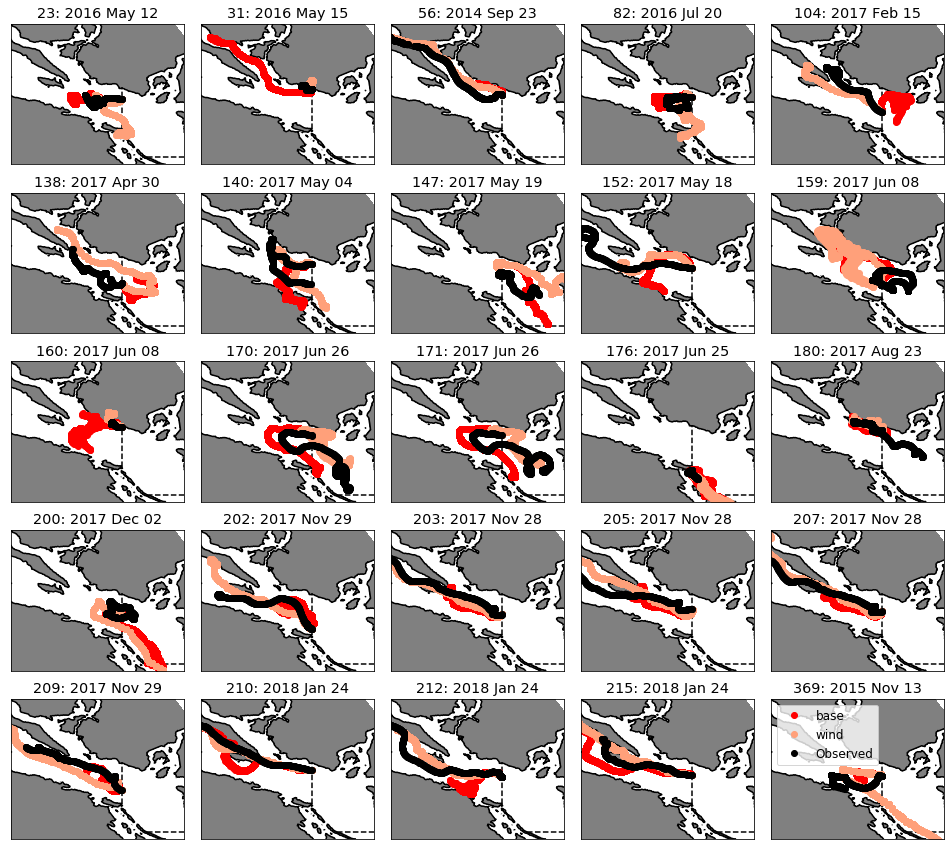

In [27]:
# Plot drifters
fig, axs = plt.subplots(5, 5, figsize=(17, 15), gridspec_kw={'wspace': 0.01})
axs = axs.flatten()
plot_drifters(axs, 'lon123.7', [-124.6, -123.2, 48.9, 49.9])
fig.savefig('/home/bmoorema/Desktop/drift_maps.pdf', bbox_inches='tight')

Skill scores

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide


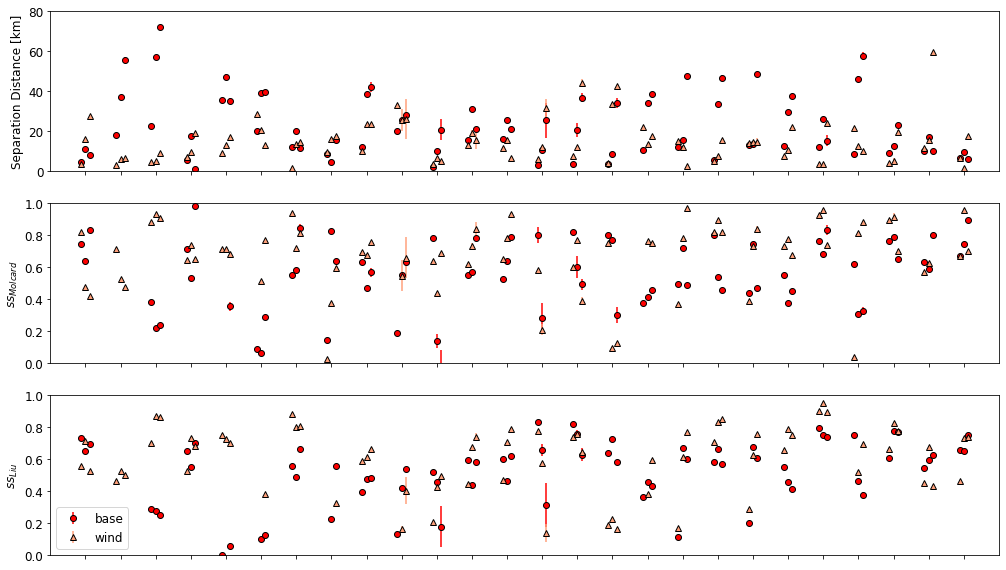

In [42]:
# Plot skill score
fig, axs = plt.subplots(3, 1, figsize=(17, 10))
plot_skill(axs, 'lon123.7')
fig.savefig('/home/bmoorema/Desktop/drift_skill.pdf', bbox_inches='tight')

***

### Haro Strait

Individual drifters

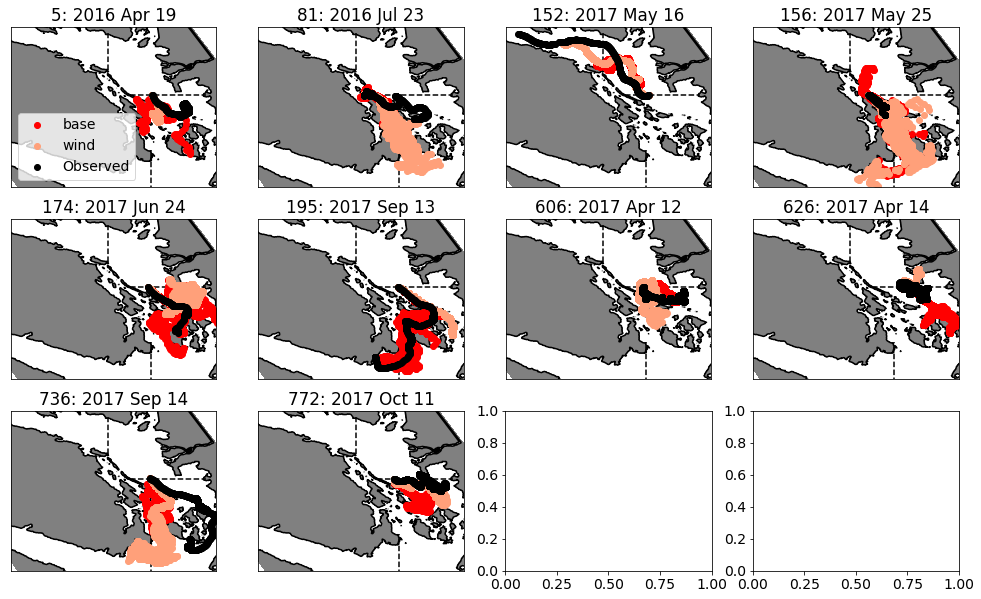

In [185]:
# Plot drifters
fig, axs = plt.subplots(3, 4, figsize=(17, 10))
axs = axs.flatten()
plot_drifters(axs, 'lat48.95', [-124.6, -122.7, 48.2, 49.5])

Skill scores

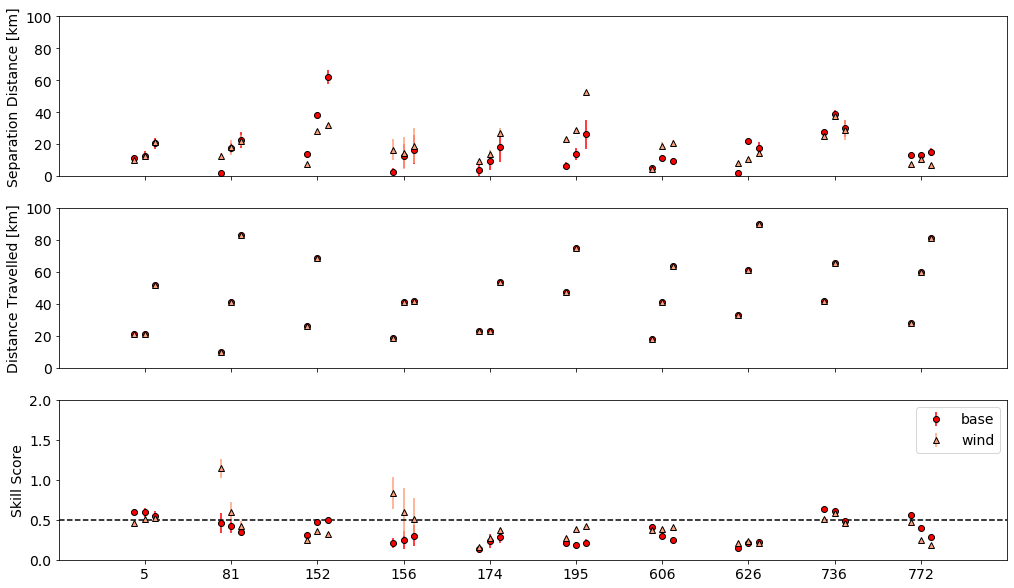

In [181]:
# Plot skill scores
fig, axs = plt.subplots(3, 1, figsize=(17, 10))
plot_skill(axs, 'lat48.95')

***

### Juan de Fuca Strait

Individual drifters

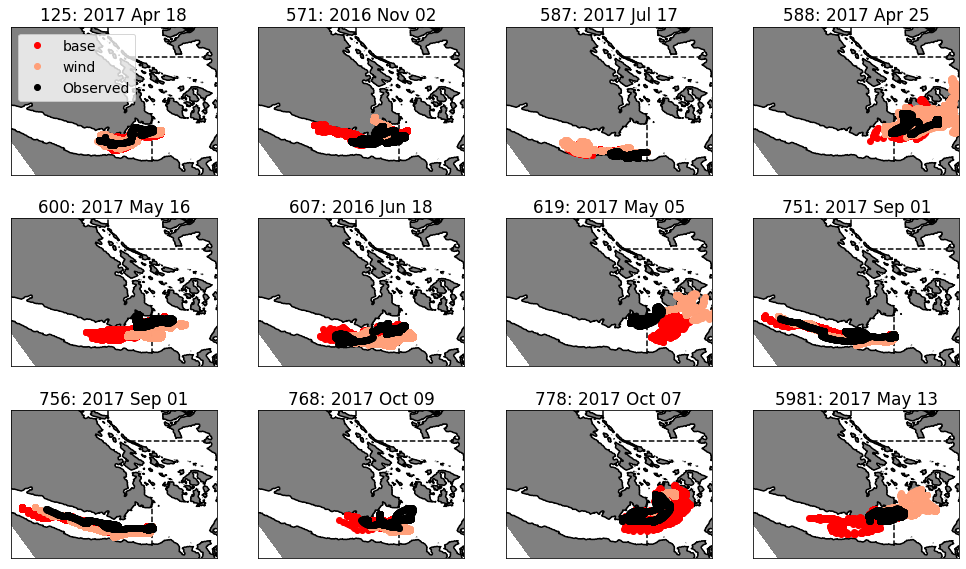

In [182]:
# Plot drifters
fig, axs = plt.subplots(3, 4, figsize=(17, 10))
axs = axs.flatten()
plot_drifters(axs, 'lon123.3', [-124.6, -122.7, 48.0, 49.2])

Skill scores

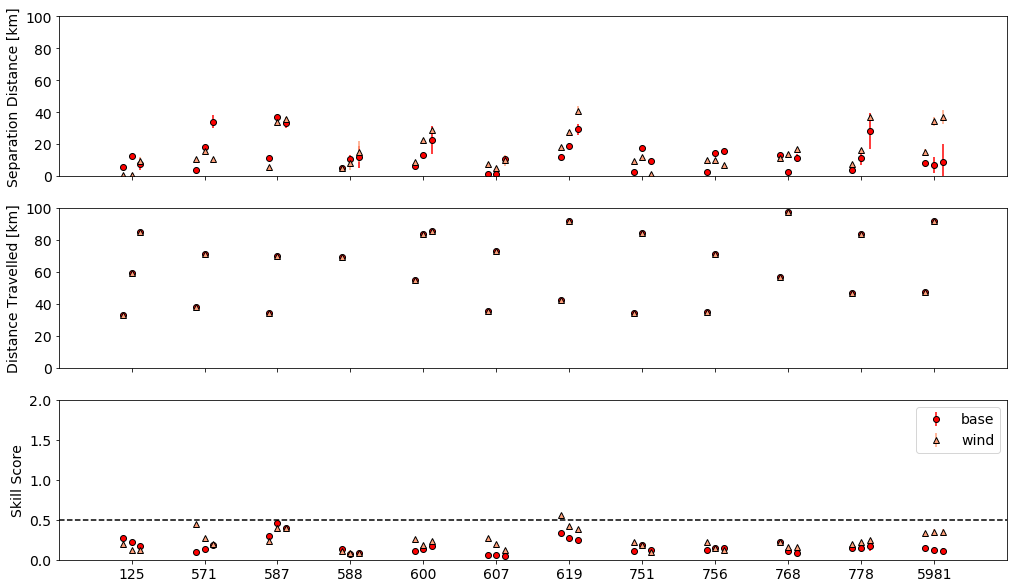

In [187]:
# Plot skill scores
fig, axs = plt.subplots(3, 1, figsize=(17, 10))
plot_skill(axs, 'lon123.3')

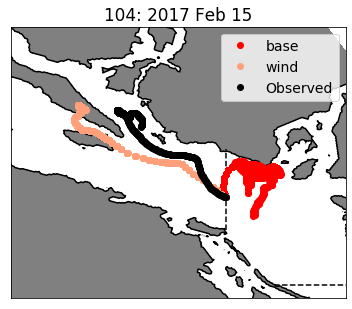

In [194]:
fig, ax = plt.subplots(figsize=(6, 8))
plot_drifters(ax, 'lon123.7', [-124.6, -123.2, 48.9, 49.9])
fig.savefig('/home/bmoorema/Desktop/drifter104.pdf', bbox_inches='tight')